In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : False,
    'right'         : False,
    'threshold'     : 0.6,
    'binarize'      : True,
    'not_connected' : True,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'native','im':'t1t2','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1t2','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'connectivity',
    'balance_data'  : True,
    'balance_ratio' : 0.25,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : False,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_CCE_7_1_025_1_0_0_1_t1t2_normalized_e_n_e_0_0_e_0_1_connectivity_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1t2_0_42_n_native_08_05_06


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(1314873, 828)
(1314873, 8)
validation
(153265, 828)
(153265, 8)
test
(189545, 828)
(189545, 8)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 1024)              848896    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 8)                 1032      


Total params: 1538952 (5.87 MB)


Trainable params: 1538952 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


  1/132 [..............................] - ETA: 2:57 - loss: 2.1217 - STD: 0.0414 - MAE: 0.2182

  5/132 [>.............................] - ETA: 2s - loss: 2.0076 - STD: 0.0833 - MAE: 0.2082  

  8/132 [>.............................] - ETA: 13s - loss: 2.0004 - STD: 0.0768 - MAE: 0.2090

 12/132 [=>............................] - ETA: 8s - loss: 1.9862 - STD: 0.0777 - MAE: 0.2085 

 16/132 [==>...........................] - ETA: 6s - loss: 1.9776 - STD: 0.0774 - MAE: 0.2082

 20/132 [===>..........................] - ETA: 5s - loss: 1.9734 - STD: 0.0743 - MAE: 0.2086

 24/132 [====>.........................] - ETA: 4s - loss: 1.9691 - STD: 0.0740 - MAE: 0.2085

 28/132 [=====>........................] - ETA: 4s - loss: 1.9644 - STD: 0.0743 - MAE: 0.2083

 32/132 [======>.......................] - ETA: 3s - loss: 1.9600 - STD: 0.0741 - MAE: 0.2081

 36/132 [=======>......................] - ETA: 3s - loss: 1.9542 - STD: 0.0740 - MAE: 0.2079

 40/132 [========>.....................] - ETA: 2s - loss: 1.9471 - STD: 0.0744 - MAE: 0.2075

 44/132 [=========>....................] - ETA: 2s - loss: 1.9396 - STD: 0.0751 - MAE: 0.2071

 48/132 [=========>....................] - ETA: 2s - loss: 1.9306 - STD: 0.0768 - MAE: 0.2065

 52/132 [==========>...................] - ETA: 2s - loss: 1.9206 - STD: 0.0783 - MAE: 0.2059

 56/132 [===========>..................] - ETA: 2s - loss: 1.9097 - STD: 0.0797 - MAE: 0.2052

 60/132 [============>.................] - ETA: 1s - loss: 1.8973 - STD: 0.0812 - MAE: 0.2045

 64/132 [=============>................] - ETA: 1s - loss: 1.8844 - STD: 0.0829 - MAE: 0.2038

 68/132 [==============>...............] - ETA: 1s - loss: 1.8708 - STD: 0.0846 - MAE: 0.2030

 72/132 [===============>..............] - ETA: 1s - loss: 1.8565 - STD: 0.0864 - MAE: 0.2022

 76/132 [================>.............] - ETA: 1s - loss: 1.8415 - STD: 0.0881 - MAE: 0.2014

 80/132 [=================>............] - ETA: 1s - loss: 1.8258 - STD: 0.0900 - MAE: 0.2004

 84/132 [==================>...........] - ETA: 1s - loss: 1.8100 - STD: 0.0917 - MAE: 0.1995

 88/132 [===================>..........] - ETA: 1s - loss: 1.7945 - STD: 0.0937 - MAE: 0.1986

 92/132 [===================>..........] - ETA: 0s - loss: 1.7796 - STD: 0.0955 - MAE: 0.1976

 96/132 [====================>.........] - ETA: 0s - loss: 1.7653 - STD: 0.0975 - MAE: 0.1967

100/132 [=====================>........] - ETA: 0s - loss: 1.7514 - STD: 0.0994 - MAE: 0.1958

104/132 [======================>.......] - ETA: 0s - loss: 1.7381 - STD: 0.1012 - MAE: 0.1948

108/132 [=======================>......] - ETA: 0s - loss: 1.7251 - STD: 0.1030 - MAE: 0.1940

112/132 [========================>.....] - ETA: 0s - loss: 1.7132 - STD: 0.1047 - MAE: 0.1931

116/132 [=========================>....] - ETA: 0s - loss: 1.7013 - STD: 0.1064 - MAE: 0.1923

120/132 [==========================>...] - ETA: 0s - loss: 1.6902 - STD: 0.1080 - MAE: 0.1915

124/132 [===========================>..] - ETA: 0s - loss: 1.6794 - STD: 0.1095 - MAE: 0.1907

128/132 [============================>.] - ETA: 0s - loss: 1.6690 - STD: 0.1110 - MAE: 0.1899

132/132 [==============================] - ETA: 0s - loss: 1.6589 - STD: 0.1125 - MAE: 0.1892

132/132 [==============================] - 5s 26ms/step - loss: 1.6589 - STD: 0.1125 - MAE: 0.1892 - val_loss: 1.2982 - val_STD: 0.1498 - val_MAE: 0.1655


Epoch 2/10000


  1/132 [..............................] - ETA: 6s - loss: 1.3402 - STD: 0.1569 - MAE: 0.1659

  5/132 [>.............................] - ETA: 1s - loss: 1.3275 - STD: 0.1594 - MAE: 0.1647

  9/132 [=>............................] - ETA: 1s - loss: 1.3245 - STD: 0.1601 - MAE: 0.1643

 13/132 [=>............................] - ETA: 1s - loss: 1.3184 - STD: 0.1614 - MAE: 0.1636

 17/132 [==>...........................] - ETA: 1s - loss: 1.3138 - STD: 0.1623 - MAE: 0.1631

 21/132 [===>..........................] - ETA: 1s - loss: 1.3107 - STD: 0.1630 - MAE: 0.1627

 25/132 [====>.........................] - ETA: 1s - loss: 1.3067 - STD: 0.1636 - MAE: 0.1623

 29/132 [=====>........................] - ETA: 1s - loss: 1.3023 - STD: 0.1643 - MAE: 0.1619

 33/132 [======>.......................] - ETA: 1s - loss: 1.2990 - STD: 0.1650 - MAE: 0.1614

 37/132 [=======>......................] - ETA: 1s - loss: 1.2953 - STD: 0.1657 - MAE: 0.1610

 41/132 [========>.....................] - ETA: 1s - loss: 1.2920 - STD: 0.1664 - MAE: 0.1606

 45/132 [=========>....................] - ETA: 1s - loss: 1.2891 - STD: 0.1672 - MAE: 0.1602

 49/132 [==========>...................] - ETA: 1s - loss: 1.2855 - STD: 0.1677 - MAE: 0.1599

 52/132 [==========>...................] - ETA: 1s - loss: 1.2838 - STD: 0.1682 - MAE: 0.1596

 55/132 [===========>..................] - ETA: 1s - loss: 1.2812 - STD: 0.1685 - MAE: 0.1594

 59/132 [============>.................] - ETA: 1s - loss: 1.2784 - STD: 0.1691 - MAE: 0.1591

 63/132 [=============>................] - ETA: 1s - loss: 1.2752 - STD: 0.1696 - MAE: 0.1588

 67/132 [==============>...............] - ETA: 1s - loss: 1.2727 - STD: 0.1701 - MAE: 0.1585

 71/132 [===============>..............] - ETA: 0s - loss: 1.2705 - STD: 0.1705 - MAE: 0.1582

 74/132 [===============>..............] - ETA: 0s - loss: 1.2688 - STD: 0.1708 - MAE: 0.1580

 78/132 [================>.............] - ETA: 0s - loss: 1.2664 - STD: 0.1712 - MAE: 0.1578

 82/132 [=================>............] - ETA: 0s - loss: 1.2639 - STD: 0.1716 - MAE: 0.1575

 86/132 [==================>...........] - ETA: 0s - loss: 1.2619 - STD: 0.1719 - MAE: 0.1573

 90/132 [===================>..........] - ETA: 0s - loss: 1.2598 - STD: 0.1723 - MAE: 0.1571

 94/132 [====================>.........] - ETA: 0s - loss: 1.2576 - STD: 0.1726 - MAE: 0.1569

 98/132 [=====================>........] - ETA: 0s - loss: 1.2559 - STD: 0.1729 - MAE: 0.1567

102/132 [======================>.......] - ETA: 0s - loss: 1.2539 - STD: 0.1733 - MAE: 0.1565

106/132 [=======================>......] - ETA: 0s - loss: 1.2517 - STD: 0.1736 - MAE: 0.1562

110/132 [========================>.....] - ETA: 0s - loss: 1.2502 - STD: 0.1739 - MAE: 0.1561

114/132 [========================>.....] - ETA: 0s - loss: 1.2481 - STD: 0.1742 - MAE: 0.1559

117/132 [=========================>....] - ETA: 0s - loss: 1.2467 - STD: 0.1744 - MAE: 0.1557

121/132 [==========================>...] - ETA: 0s - loss: 1.2449 - STD: 0.1747 - MAE: 0.1556

125/132 [===========================>..] - ETA: 0s - loss: 1.2430 - STD: 0.1749 - MAE: 0.1554

129/132 [============================>.] - ETA: 0s - loss: 1.2411 - STD: 0.1752 - MAE: 0.1552

132/132 [==============================] - 2s 18ms/step - loss: 1.2399 - STD: 0.1754 - MAE: 0.1551 - val_loss: 1.1798 - val_STD: 0.1793 - val_MAE: 0.1502


Epoch 3/10000


  1/132 [..............................] - ETA: 6s - loss: 1.1840 - STD: 0.1862 - MAE: 0.1489

  5/132 [>.............................] - ETA: 2s - loss: 1.1840 - STD: 0.1846 - MAE: 0.1489

  9/132 [=>............................] - ETA: 1s - loss: 1.1917 - STD: 0.1848 - MAE: 0.1494

 13/132 [=>............................] - ETA: 1s - loss: 1.1909 - STD: 0.1851 - MAE: 0.1493

 17/132 [==>...........................] - ETA: 1s - loss: 1.1911 - STD: 0.1851 - MAE: 0.1493

 21/132 [===>..........................] - ETA: 1s - loss: 1.1874 - STD: 0.1851 - MAE: 0.1491

 25/132 [====>.........................] - ETA: 1s - loss: 1.1852 - STD: 0.1850 - MAE: 0.1491

 29/132 [=====>........................] - ETA: 1s - loss: 1.1839 - STD: 0.1852 - MAE: 0.1490

 32/132 [======>.......................] - ETA: 1s - loss: 1.1834 - STD: 0.1852 - MAE: 0.1490

 36/132 [=======>......................] - ETA: 1s - loss: 1.1814 - STD: 0.1854 - MAE: 0.1488

 40/132 [========>.....................] - ETA: 1s - loss: 1.1803 - STD: 0.1855 - MAE: 0.1488

 43/132 [========>.....................] - ETA: 1s - loss: 1.1797 - STD: 0.1854 - MAE: 0.1487

 47/132 [=========>....................] - ETA: 1s - loss: 1.1780 - STD: 0.1855 - MAE: 0.1486

 51/132 [==========>...................] - ETA: 1s - loss: 1.1761 - STD: 0.1857 - MAE: 0.1485

 55/132 [===========>..................] - ETA: 1s - loss: 1.1749 - STD: 0.1858 - MAE: 0.1484

 59/132 [============>.................] - ETA: 1s - loss: 1.1738 - STD: 0.1859 - MAE: 0.1483

 63/132 [=============>................] - ETA: 1s - loss: 1.1727 - STD: 0.1861 - MAE: 0.1482

 67/132 [==============>...............] - ETA: 1s - loss: 1.1709 - STD: 0.1862 - MAE: 0.1480

 71/132 [===============>..............] - ETA: 0s - loss: 1.1696 - STD: 0.1863 - MAE: 0.1480

 75/132 [================>.............] - ETA: 0s - loss: 1.1691 - STD: 0.1865 - MAE: 0.1479

 79/132 [================>.............] - ETA: 0s - loss: 1.1681 - STD: 0.1866 - MAE: 0.1478

 83/132 [=================>............] - ETA: 0s - loss: 1.1671 - STD: 0.1868 - MAE: 0.1476

 87/132 [==================>...........] - ETA: 0s - loss: 1.1664 - STD: 0.1870 - MAE: 0.1476

 91/132 [===================>..........] - ETA: 0s - loss: 1.1650 - STD: 0.1871 - MAE: 0.1475

 95/132 [====================>.........] - ETA: 0s - loss: 1.1637 - STD: 0.1873 - MAE: 0.1473

 99/132 [=====================>........] - ETA: 0s - loss: 1.1629 - STD: 0.1874 - MAE: 0.1472

103/132 [======================>.......] - ETA: 0s - loss: 1.1619 - STD: 0.1874 - MAE: 0.1472

107/132 [=======================>......] - ETA: 0s - loss: 1.1607 - STD: 0.1876 - MAE: 0.1471

111/132 [========================>.....] - ETA: 0s - loss: 1.1596 - STD: 0.1877 - MAE: 0.1470

115/132 [=========================>....] - ETA: 0s - loss: 1.1586 - STD: 0.1879 - MAE: 0.1469

119/132 [==========================>...] - ETA: 0s - loss: 1.1577 - STD: 0.1880 - MAE: 0.1468

123/132 [==========================>...] - ETA: 0s - loss: 1.1578 - STD: 0.1881 - MAE: 0.1468

127/132 [===========================>..] - ETA: 0s - loss: 1.1571 - STD: 0.1882 - MAE: 0.1467

131/132 [============================>.] - ETA: 0s - loss: 1.1561 - STD: 0.1883 - MAE: 0.1466

132/132 [==============================] - 2s 18ms/step - loss: 1.1559 - STD: 0.1884 - MAE: 0.1466 - val_loss: 1.1214 - val_STD: 0.1872 - val_MAE: 0.1458


Epoch 4/10000


  1/132 [..............................] - ETA: 6s - loss: 1.1260 - STD: 0.1898 - MAE: 0.1446

  4/132 [..............................] - ETA: 2s - loss: 1.1211 - STD: 0.1912 - MAE: 0.1438

  8/132 [>.............................] - ETA: 2s - loss: 1.1189 - STD: 0.1917 - MAE: 0.1436

 12/132 [=>............................] - ETA: 1s - loss: 1.1211 - STD: 0.1920 - MAE: 0.1436

 16/132 [==>...........................] - ETA: 1s - loss: 1.1210 - STD: 0.1923 - MAE: 0.1435

 20/132 [===>..........................] - ETA: 1s - loss: 1.1211 - STD: 0.1924 - MAE: 0.1435

 24/132 [====>.........................] - ETA: 1s - loss: 1.1198 - STD: 0.1925 - MAE: 0.1434

 28/132 [=====>........................] - ETA: 1s - loss: 1.1197 - STD: 0.1927 - MAE: 0.1433

 32/132 [======>.......................] - ETA: 1s - loss: 1.1188 - STD: 0.1928 - MAE: 0.1432

 36/132 [=======>......................] - ETA: 1s - loss: 1.1193 - STD: 0.1929 - MAE: 0.1432

 40/132 [========>.....................] - ETA: 1s - loss: 1.1191 - STD: 0.1929 - MAE: 0.1432

 44/132 [=========>....................] - ETA: 1s - loss: 1.1189 - STD: 0.1931 - MAE: 0.1431

 48/132 [=========>....................] - ETA: 1s - loss: 1.1184 - STD: 0.1932 - MAE: 0.1430

 52/132 [==========>...................] - ETA: 1s - loss: 1.1181 - STD: 0.1933 - MAE: 0.1430

 55/132 [===========>..................] - ETA: 1s - loss: 1.1175 - STD: 0.1934 - MAE: 0.1429

 59/132 [============>.................] - ETA: 1s - loss: 1.1166 - STD: 0.1935 - MAE: 0.1429

 63/132 [=============>................] - ETA: 1s - loss: 1.1165 - STD: 0.1936 - MAE: 0.1428

 67/132 [==============>...............] - ETA: 0s - loss: 1.1160 - STD: 0.1936 - MAE: 0.1428

 71/132 [===============>..............] - ETA: 0s - loss: 1.1156 - STD: 0.1937 - MAE: 0.1427

 75/132 [================>.............] - ETA: 0s - loss: 1.1150 - STD: 0.1937 - MAE: 0.1427

 79/132 [================>.............] - ETA: 0s - loss: 1.1139 - STD: 0.1938 - MAE: 0.1426

 83/132 [=================>............] - ETA: 0s - loss: 1.1133 - STD: 0.1938 - MAE: 0.1426

 87/132 [==================>...........] - ETA: 0s - loss: 1.1125 - STD: 0.1939 - MAE: 0.1425

 91/132 [===================>..........] - ETA: 0s - loss: 1.1116 - STD: 0.1940 - MAE: 0.1424

 95/132 [====================>.........] - ETA: 0s - loss: 1.1114 - STD: 0.1941 - MAE: 0.1424

 99/132 [=====================>........] - ETA: 0s - loss: 1.1107 - STD: 0.1942 - MAE: 0.1423

103/132 [======================>.......] - ETA: 0s - loss: 1.1102 - STD: 0.1943 - MAE: 0.1422

107/132 [=======================>......] - ETA: 0s - loss: 1.1095 - STD: 0.1943 - MAE: 0.1422

111/132 [========================>.....] - ETA: 0s - loss: 1.1084 - STD: 0.1945 - MAE: 0.1421

115/132 [=========================>....] - ETA: 0s - loss: 1.1080 - STD: 0.1945 - MAE: 0.1420

119/132 [==========================>...] - ETA: 0s - loss: 1.1077 - STD: 0.1946 - MAE: 0.1420

123/132 [==========================>...] - ETA: 0s - loss: 1.1071 - STD: 0.1947 - MAE: 0.1419

127/132 [===========================>..] - ETA: 0s - loss: 1.1068 - STD: 0.1948 - MAE: 0.1419

131/132 [============================>.] - ETA: 0s - loss: 1.1064 - STD: 0.1948 - MAE: 0.1419

132/132 [==============================] - 2s 17ms/step - loss: 1.1063 - STD: 0.1948 - MAE: 0.1419 - val_loss: 1.1032 - val_STD: 0.1944 - val_MAE: 0.1423


Epoch 5/10000


  1/132 [..............................] - ETA: 6s - loss: 1.1022 - STD: 0.1970 - MAE: 0.1408

  5/132 [>.............................] - ETA: 1s - loss: 1.0842 - STD: 0.1963 - MAE: 0.1402

  9/132 [=>............................] - ETA: 1s - loss: 1.0906 - STD: 0.1971 - MAE: 0.1402

 13/132 [=>............................] - ETA: 1s - loss: 1.0907 - STD: 0.1972 - MAE: 0.1402

 17/132 [==>...........................] - ETA: 1s - loss: 1.0928 - STD: 0.1971 - MAE: 0.1404

 21/132 [===>..........................] - ETA: 1s - loss: 1.0969 - STD: 0.1970 - MAE: 0.1406

 25/132 [====>.........................] - ETA: 1s - loss: 1.0959 - STD: 0.1972 - MAE: 0.1405

 28/132 [=====>........................] - ETA: 1s - loss: 1.0958 - STD: 0.1971 - MAE: 0.1405

 32/132 [======>.......................] - ETA: 1s - loss: 1.0944 - STD: 0.1971 - MAE: 0.1404

 35/132 [======>.......................] - ETA: 1s - loss: 1.0931 - STD: 0.1971 - MAE: 0.1404

 38/132 [=======>......................] - ETA: 1s - loss: 1.0916 - STD: 0.1972 - MAE: 0.1403

 41/132 [========>.....................] - ETA: 1s - loss: 1.0906 - STD: 0.1972 - MAE: 0.1402

 45/132 [=========>....................] - ETA: 1s - loss: 1.0896 - STD: 0.1972 - MAE: 0.1402

 48/132 [=========>....................] - ETA: 1s - loss: 1.0884 - STD: 0.1972 - MAE: 0.1401

 52/132 [==========>...................] - ETA: 1s - loss: 1.0860 - STD: 0.1973 - MAE: 0.1399

 55/132 [===========>..................] - ETA: 1s - loss: 1.0845 - STD: 0.1974 - MAE: 0.1398

 58/132 [============>.................] - ETA: 1s - loss: 1.0837 - STD: 0.1975 - MAE: 0.1398

 61/132 [============>.................] - ETA: 1s - loss: 1.0830 - STD: 0.1975 - MAE: 0.1397

 64/132 [=============>................] - ETA: 1s - loss: 1.0820 - STD: 0.1976 - MAE: 0.1396

 68/132 [==============>...............] - ETA: 1s - loss: 1.0816 - STD: 0.1977 - MAE: 0.1396

 72/132 [===============>..............] - ETA: 0s - loss: 1.0813 - STD: 0.1978 - MAE: 0.1395

 76/132 [================>.............] - ETA: 0s - loss: 1.0800 - STD: 0.1979 - MAE: 0.1394

 80/132 [=================>............] - ETA: 0s - loss: 1.0792 - STD: 0.1980 - MAE: 0.1393

 83/132 [=================>............] - ETA: 0s - loss: 1.0788 - STD: 0.1981 - MAE: 0.1393

 87/132 [==================>...........] - ETA: 0s - loss: 1.0779 - STD: 0.1981 - MAE: 0.1392

 90/132 [===================>..........] - ETA: 0s - loss: 1.0775 - STD: 0.1982 - MAE: 0.1392

 94/132 [====================>.........] - ETA: 0s - loss: 1.0775 - STD: 0.1982 - MAE: 0.1392

 98/132 [=====================>........] - ETA: 0s - loss: 1.0768 - STD: 0.1983 - MAE: 0.1391

102/132 [======================>.......] - ETA: 0s - loss: 1.0763 - STD: 0.1983 - MAE: 0.1391

106/132 [=======================>......] - ETA: 0s - loss: 1.0761 - STD: 0.1984 - MAE: 0.1391

110/132 [========================>.....] - ETA: 0s - loss: 1.0750 - STD: 0.1985 - MAE: 0.1390

114/132 [========================>.....] - ETA: 0s - loss: 1.0746 - STD: 0.1985 - MAE: 0.1389

118/132 [=========================>....] - ETA: 0s - loss: 1.0742 - STD: 0.1986 - MAE: 0.1389

122/132 [==========================>...] - ETA: 0s - loss: 1.0737 - STD: 0.1987 - MAE: 0.1388

126/132 [===========================>..] - ETA: 0s - loss: 1.0733 - STD: 0.1987 - MAE: 0.1388

130/132 [============================>.] - ETA: 0s - loss: 1.0728 - STD: 0.1988 - MAE: 0.1387

132/132 [==============================] - 2s 18ms/step - loss: 1.0731 - STD: 0.1988 - MAE: 0.1387 - val_loss: 1.1108 - val_STD: 0.1997 - val_MAE: 0.1414


Epoch 6/10000


  1/132 [..............................] - ETA: 5s - loss: 1.0732 - STD: 0.2003 - MAE: 0.1381

  4/132 [..............................] - ETA: 2s - loss: 1.0646 - STD: 0.2013 - MAE: 0.1373

  8/132 [>.............................] - ETA: 2s - loss: 1.0591 - STD: 0.2011 - MAE: 0.1371

 12/132 [=>............................] - ETA: 1s - loss: 1.0586 - STD: 0.2007 - MAE: 0.1373

 15/132 [==>...........................] - ETA: 1s - loss: 1.0574 - STD: 0.2007 - MAE: 0.1372

 18/132 [===>..........................] - ETA: 1s - loss: 1.0565 - STD: 0.2009 - MAE: 0.1371

 21/132 [===>..........................] - ETA: 1s - loss: 1.0563 - STD: 0.2008 - MAE: 0.1371

 24/132 [====>.........................] - ETA: 1s - loss: 1.0562 - STD: 0.2009 - MAE: 0.1371

 28/132 [=====>........................] - ETA: 1s - loss: 1.0543 - STD: 0.2010 - MAE: 0.1370

 32/132 [======>.......................] - ETA: 1s - loss: 1.0517 - STD: 0.2010 - MAE: 0.1368

 36/132 [=======>......................] - ETA: 1s - loss: 1.0517 - STD: 0.2011 - MAE: 0.1368

 40/132 [========>.....................] - ETA: 1s - loss: 1.0513 - STD: 0.2012 - MAE: 0.1367

 44/132 [=========>....................] - ETA: 1s - loss: 1.0507 - STD: 0.2012 - MAE: 0.1367

 47/132 [=========>....................] - ETA: 1s - loss: 1.0505 - STD: 0.2012 - MAE: 0.1367

 50/132 [==========>...................] - ETA: 1s - loss: 1.0500 - STD: 0.2011 - MAE: 0.1367

 54/132 [===========>..................] - ETA: 1s - loss: 1.0498 - STD: 0.2012 - MAE: 0.1366

 58/132 [============>.................] - ETA: 1s - loss: 1.0496 - STD: 0.2013 - MAE: 0.1366

 62/132 [=============>................] - ETA: 1s - loss: 1.0496 - STD: 0.2014 - MAE: 0.1365

 65/132 [=============>................] - ETA: 1s - loss: 1.0492 - STD: 0.2014 - MAE: 0.1365

 68/132 [==============>...............] - ETA: 1s - loss: 1.0487 - STD: 0.2015 - MAE: 0.1364

 71/132 [===============>..............] - ETA: 1s - loss: 1.0478 - STD: 0.2015 - MAE: 0.1364

 75/132 [================>.............] - ETA: 0s - loss: 1.0473 - STD: 0.2016 - MAE: 0.1363

 79/132 [================>.............] - ETA: 0s - loss: 1.0480 - STD: 0.2016 - MAE: 0.1363

 83/132 [=================>............] - ETA: 0s - loss: 1.0478 - STD: 0.2017 - MAE: 0.1363

 87/132 [==================>...........] - ETA: 0s - loss: 1.0474 - STD: 0.2017 - MAE: 0.1363

 91/132 [===================>..........] - ETA: 0s - loss: 1.0470 - STD: 0.2017 - MAE: 0.1363

 94/132 [====================>.........] - ETA: 0s - loss: 1.0471 - STD: 0.2017 - MAE: 0.1363

 98/132 [=====================>........] - ETA: 0s - loss: 1.0466 - STD: 0.2018 - MAE: 0.1362

101/132 [=====================>........] - ETA: 0s - loss: 1.0462 - STD: 0.2018 - MAE: 0.1362

105/132 [======================>.......] - ETA: 0s - loss: 1.0459 - STD: 0.2019 - MAE: 0.1361

109/132 [=======================>......] - ETA: 0s - loss: 1.0455 - STD: 0.2019 - MAE: 0.1361

113/132 [========================>.....] - ETA: 0s - loss: 1.0455 - STD: 0.2019 - MAE: 0.1361

117/132 [=========================>....] - ETA: 0s - loss: 1.0451 - STD: 0.2020 - MAE: 0.1361

121/132 [==========================>...] - ETA: 0s - loss: 1.0448 - STD: 0.2021 - MAE: 0.1360

125/132 [===========================>..] - ETA: 0s - loss: 1.0449 - STD: 0.2021 - MAE: 0.1360

129/132 [============================>.] - ETA: 0s - loss: 1.0446 - STD: 0.2021 - MAE: 0.1360

132/132 [==============================] - 2s 18ms/step - loss: 1.0444 - STD: 0.2022 - MAE: 0.1359 - val_loss: 1.0667 - val_STD: 0.2007 - val_MAE: 0.1390


Epoch 7/10000


  1/132 [..............................] - ETA: 5s - loss: 1.0274 - STD: 0.2006 - MAE: 0.1357

  5/132 [>.............................] - ETA: 2s - loss: 1.0278 - STD: 0.2031 - MAE: 0.1348

  9/132 [=>............................] - ETA: 2s - loss: 1.0254 - STD: 0.2038 - MAE: 0.1343

 13/132 [=>............................] - ETA: 1s - loss: 1.0285 - STD: 0.2038 - MAE: 0.1345

 17/132 [==>...........................] - ETA: 1s - loss: 1.0311 - STD: 0.2038 - MAE: 0.1346

 21/132 [===>..........................] - ETA: 1s - loss: 1.0302 - STD: 0.2038 - MAE: 0.1346

 25/132 [====>.........................] - ETA: 1s - loss: 1.0289 - STD: 0.2039 - MAE: 0.1345

 28/132 [=====>........................] - ETA: 1s - loss: 1.0291 - STD: 0.2039 - MAE: 0.1344

 31/132 [======>.......................] - ETA: 1s - loss: 1.0283 - STD: 0.2040 - MAE: 0.1344

 35/132 [======>.......................] - ETA: 1s - loss: 1.0270 - STD: 0.2041 - MAE: 0.1342

 39/132 [=======>......................] - ETA: 1s - loss: 1.0260 - STD: 0.2042 - MAE: 0.1342

 43/132 [========>.....................] - ETA: 1s - loss: 1.0251 - STD: 0.2043 - MAE: 0.1341

 47/132 [=========>....................] - ETA: 1s - loss: 1.0255 - STD: 0.2043 - MAE: 0.1341

 51/132 [==========>...................] - ETA: 1s - loss: 1.0250 - STD: 0.2044 - MAE: 0.1340

 55/132 [===========>..................] - ETA: 1s - loss: 1.0243 - STD: 0.2044 - MAE: 0.1339

 58/132 [============>.................] - ETA: 1s - loss: 1.0243 - STD: 0.2045 - MAE: 0.1339

 61/132 [============>.................] - ETA: 1s - loss: 1.0238 - STD: 0.2046 - MAE: 0.1338

 65/132 [=============>................] - ETA: 1s - loss: 1.0236 - STD: 0.2046 - MAE: 0.1338

 69/132 [==============>...............] - ETA: 1s - loss: 1.0241 - STD: 0.2046 - MAE: 0.1339

 73/132 [===============>..............] - ETA: 0s - loss: 1.0248 - STD: 0.2046 - MAE: 0.1339

 76/132 [================>.............] - ETA: 0s - loss: 1.0248 - STD: 0.2047 - MAE: 0.1339

 79/132 [================>.............] - ETA: 0s - loss: 1.0242 - STD: 0.2047 - MAE: 0.1338

 82/132 [=================>............] - ETA: 0s - loss: 1.0236 - STD: 0.2047 - MAE: 0.1338

 85/132 [==================>...........] - ETA: 0s - loss: 1.0232 - STD: 0.2048 - MAE: 0.1338

 89/132 [===================>..........] - ETA: 0s - loss: 1.0223 - STD: 0.2048 - MAE: 0.1337

 93/132 [====================>.........] - ETA: 0s - loss: 1.0217 - STD: 0.2048 - MAE: 0.1337

 97/132 [=====================>........] - ETA: 0s - loss: 1.0207 - STD: 0.2049 - MAE: 0.1336

101/132 [=====================>........] - ETA: 0s - loss: 1.0204 - STD: 0.2049 - MAE: 0.1336

105/132 [======================>.......] - ETA: 0s - loss: 1.0211 - STD: 0.2050 - MAE: 0.1336

109/132 [=======================>......] - ETA: 0s - loss: 1.0204 - STD: 0.2051 - MAE: 0.1335

113/132 [========================>.....] - ETA: 0s - loss: 1.0197 - STD: 0.2051 - MAE: 0.1334

117/132 [=========================>....] - ETA: 0s - loss: 1.0193 - STD: 0.2052 - MAE: 0.1334

121/132 [==========================>...] - ETA: 0s - loss: 1.0186 - STD: 0.2053 - MAE: 0.1333

125/132 [===========================>..] - ETA: 0s - loss: 1.0184 - STD: 0.2053 - MAE: 0.1333

129/132 [============================>.] - ETA: 0s - loss: 1.0180 - STD: 0.2053 - MAE: 0.1333

132/132 [==============================] - 2s 18ms/step - loss: 1.0176 - STD: 0.2054 - MAE: 0.1332 - val_loss: 1.0575 - val_STD: 0.2084 - val_MAE: 0.1351


Epoch 8/10000


  1/132 [..............................] - ETA: 7s - loss: 1.0373 - STD: 0.2105 - MAE: 0.1326

  4/132 [..............................] - ETA: 2s - loss: 1.0207 - STD: 0.2069 - MAE: 0.1329

  8/132 [>.............................] - ETA: 2s - loss: 1.0090 - STD: 0.2063 - MAE: 0.1325

 12/132 [=>............................] - ETA: 1s - loss: 1.0036 - STD: 0.2066 - MAE: 0.1320

 16/132 [==>...........................] - ETA: 1s - loss: 1.0029 - STD: 0.2070 - MAE: 0.1318

 19/132 [===>..........................] - ETA: 1s - loss: 1.0022 - STD: 0.2071 - MAE: 0.1317

 22/132 [====>.........................] - ETA: 1s - loss: 1.0013 - STD: 0.2070 - MAE: 0.1317

 26/132 [====>.........................] - ETA: 1s - loss: 1.0024 - STD: 0.2071 - MAE: 0.1317

 30/132 [=====>........................] - ETA: 1s - loss: 1.0036 - STD: 0.2073 - MAE: 0.1317

 34/132 [======>.......................] - ETA: 1s - loss: 1.0045 - STD: 0.2073 - MAE: 0.1317

 38/132 [=======>......................] - ETA: 1s - loss: 1.0067 - STD: 0.2073 - MAE: 0.1319

 42/132 [========>.....................] - ETA: 1s - loss: 1.0055 - STD: 0.2073 - MAE: 0.1318

 45/132 [=========>....................] - ETA: 1s - loss: 1.0046 - STD: 0.2073 - MAE: 0.1317

 48/132 [=========>....................] - ETA: 1s - loss: 1.0034 - STD: 0.2074 - MAE: 0.1317

 51/132 [==========>...................] - ETA: 1s - loss: 1.0029 - STD: 0.2074 - MAE: 0.1316

 54/132 [===========>..................] - ETA: 1s - loss: 1.0020 - STD: 0.2074 - MAE: 0.1316

 57/132 [===========>..................] - ETA: 1s - loss: 1.0014 - STD: 0.2075 - MAE: 0.1315

 61/132 [============>.................] - ETA: 1s - loss: 1.0006 - STD: 0.2075 - MAE: 0.1315

 65/132 [=============>................] - ETA: 1s - loss: 0.9997 - STD: 0.2075 - MAE: 0.1314

 69/132 [==============>...............] - ETA: 1s - loss: 0.9995 - STD: 0.2077 - MAE: 0.1313

 73/132 [===============>..............] - ETA: 0s - loss: 0.9992 - STD: 0.2077 - MAE: 0.1313

 77/132 [================>.............] - ETA: 0s - loss: 0.9986 - STD: 0.2078 - MAE: 0.1312

 80/132 [=================>............] - ETA: 0s - loss: 0.9992 - STD: 0.2078 - MAE: 0.1313

 83/132 [=================>............] - ETA: 0s - loss: 0.9989 - STD: 0.2078 - MAE: 0.1312

 87/132 [==================>...........] - ETA: 0s - loss: 0.9982 - STD: 0.2079 - MAE: 0.1312

 91/132 [===================>..........] - ETA: 0s - loss: 0.9979 - STD: 0.2079 - MAE: 0.1311

 94/132 [====================>.........] - ETA: 0s - loss: 0.9977 - STD: 0.2080 - MAE: 0.1311

 97/132 [=====================>........] - ETA: 0s - loss: 0.9972 - STD: 0.2080 - MAE: 0.1311

100/132 [=====================>........] - ETA: 0s - loss: 0.9969 - STD: 0.2080 - MAE: 0.1310

104/132 [======================>.......] - ETA: 0s - loss: 0.9965 - STD: 0.2081 - MAE: 0.1310

107/132 [=======================>......] - ETA: 0s - loss: 0.9966 - STD: 0.2081 - MAE: 0.1310

110/132 [========================>.....] - ETA: 0s - loss: 0.9969 - STD: 0.2081 - MAE: 0.1310

114/132 [========================>.....] - ETA: 0s - loss: 0.9967 - STD: 0.2081 - MAE: 0.1310

117/132 [=========================>....] - ETA: 0s - loss: 0.9965 - STD: 0.2081 - MAE: 0.1310

121/132 [==========================>...] - ETA: 0s - loss: 0.9964 - STD: 0.2082 - MAE: 0.1310

124/132 [===========================>..] - ETA: 0s - loss: 0.9963 - STD: 0.2082 - MAE: 0.1309

128/132 [============================>.] - ETA: 0s - loss: 0.9965 - STD: 0.2082 - MAE: 0.1309

132/132 [==============================] - ETA: 0s - loss: 0.9964 - STD: 0.2082 - MAE: 0.1309

132/132 [==============================] - 2s 18ms/step - loss: 0.9964 - STD: 0.2082 - MAE: 0.1309 - val_loss: 1.0515 - val_STD: 0.2062 - val_MAE: 0.1355


Epoch 9/10000


  1/132 [..............................] - ETA: 4s - loss: 0.9797 - STD: 0.2092 - MAE: 0.1298

  5/132 [>.............................] - ETA: 2s - loss: 0.9897 - STD: 0.2087 - MAE: 0.1304

  9/132 [=>............................] - ETA: 1s - loss: 0.9890 - STD: 0.2091 - MAE: 0.1302

 13/132 [=>............................] - ETA: 1s - loss: 0.9870 - STD: 0.2093 - MAE: 0.1299

 17/132 [==>...........................] - ETA: 1s - loss: 0.9878 - STD: 0.2094 - MAE: 0.1299

 21/132 [===>..........................] - ETA: 1s - loss: 0.9879 - STD: 0.2096 - MAE: 0.1299

 25/132 [====>.........................] - ETA: 1s - loss: 0.9890 - STD: 0.2095 - MAE: 0.1300

 29/132 [=====>........................] - ETA: 1s - loss: 0.9877 - STD: 0.2095 - MAE: 0.1299

 33/132 [======>.......................] - ETA: 1s - loss: 0.9858 - STD: 0.2095 - MAE: 0.1298

 37/132 [=======>......................] - ETA: 1s - loss: 0.9853 - STD: 0.2096 - MAE: 0.1297

 41/132 [========>.....................] - ETA: 1s - loss: 0.9848 - STD: 0.2096 - MAE: 0.1297

 45/132 [=========>....................] - ETA: 1s - loss: 0.9835 - STD: 0.2095 - MAE: 0.1297

 49/132 [==========>...................] - ETA: 1s - loss: 0.9839 - STD: 0.2096 - MAE: 0.1297

 53/132 [===========>..................] - ETA: 1s - loss: 0.9837 - STD: 0.2097 - MAE: 0.1296

 57/132 [===========>..................] - ETA: 1s - loss: 0.9855 - STD: 0.2098 - MAE: 0.1297

 61/132 [============>.................] - ETA: 1s - loss: 0.9862 - STD: 0.2098 - MAE: 0.1297

 65/132 [=============>................] - ETA: 1s - loss: 0.9859 - STD: 0.2099 - MAE: 0.1297

 69/132 [==============>...............] - ETA: 0s - loss: 0.9863 - STD: 0.2099 - MAE: 0.1297

 73/132 [===============>..............] - ETA: 0s - loss: 0.9859 - STD: 0.2099 - MAE: 0.1296

 77/132 [================>.............] - ETA: 0s - loss: 0.9855 - STD: 0.2099 - MAE: 0.1296

 81/132 [=================>............] - ETA: 0s - loss: 0.9850 - STD: 0.2099 - MAE: 0.1296

 85/132 [==================>...........] - ETA: 0s - loss: 0.9844 - STD: 0.2099 - MAE: 0.1296

 88/132 [===================>..........] - ETA: 0s - loss: 0.9839 - STD: 0.2099 - MAE: 0.1295

 92/132 [===================>..........] - ETA: 0s - loss: 0.9834 - STD: 0.2099 - MAE: 0.1295

 96/132 [====================>.........] - ETA: 0s - loss: 0.9830 - STD: 0.2100 - MAE: 0.1294

 98/132 [=====================>........] - ETA: 0s - loss: 0.9829 - STD: 0.2100 - MAE: 0.1294

102/132 [======================>.......] - ETA: 0s - loss: 0.9832 - STD: 0.2100 - MAE: 0.1294

106/132 [=======================>......] - ETA: 0s - loss: 0.9833 - STD: 0.2100 - MAE: 0.1294

110/132 [========================>.....] - ETA: 0s - loss: 0.9827 - STD: 0.2101 - MAE: 0.1294

114/132 [========================>.....] - ETA: 0s - loss: 0.9823 - STD: 0.2101 - MAE: 0.1294

118/132 [=========================>....] - ETA: 0s - loss: 0.9816 - STD: 0.2101 - MAE: 0.1293

122/132 [==========================>...] - ETA: 0s - loss: 0.9808 - STD: 0.2102 - MAE: 0.1293

126/132 [===========================>..] - ETA: 0s - loss: 0.9804 - STD: 0.2102 - MAE: 0.1292

129/132 [============================>.] - ETA: 0s - loss: 0.9803 - STD: 0.2103 - MAE: 0.1292

132/132 [==============================] - 2s 18ms/step - loss: 0.9799 - STD: 0.2103 - MAE: 0.1292 - val_loss: 1.0473 - val_STD: 0.2105 - val_MAE: 0.1340


Epoch 10/10000


  1/132 [..............................] - ETA: 6s - loss: 0.9767 - STD: 0.2124 - MAE: 0.1283

  4/132 [..............................] - ETA: 2s - loss: 0.9661 - STD: 0.2125 - MAE: 0.1273

  7/132 [>.............................] - ETA: 2s - loss: 0.9628 - STD: 0.2126 - MAE: 0.1270

 10/132 [=>............................] - ETA: 2s - loss: 0.9637 - STD: 0.2125 - MAE: 0.1272

 13/132 [=>............................] - ETA: 2s - loss: 0.9637 - STD: 0.2124 - MAE: 0.1273

 17/132 [==>...........................] - ETA: 1s - loss: 0.9679 - STD: 0.2122 - MAE: 0.1276

 20/132 [===>..........................] - ETA: 1s - loss: 0.9689 - STD: 0.2122 - MAE: 0.1277

 23/132 [====>.........................] - ETA: 1s - loss: 0.9680 - STD: 0.2122 - MAE: 0.1276

 26/132 [====>.........................] - ETA: 1s - loss: 0.9679 - STD: 0.2121 - MAE: 0.1277

 29/132 [=====>........................] - ETA: 1s - loss: 0.9679 - STD: 0.2121 - MAE: 0.1277

 32/132 [======>.......................] - ETA: 1s - loss: 0.9692 - STD: 0.2121 - MAE: 0.1277

 35/132 [======>.......................] - ETA: 1s - loss: 0.9694 - STD: 0.2122 - MAE: 0.1277

 38/132 [=======>......................] - ETA: 1s - loss: 0.9727 - STD: 0.2121 - MAE: 0.1279

 41/132 [========>.....................] - ETA: 1s - loss: 0.9740 - STD: 0.2121 - MAE: 0.1280

 44/132 [=========>....................] - ETA: 1s - loss: 0.9747 - STD: 0.2120 - MAE: 0.1281

 47/132 [=========>....................] - ETA: 1s - loss: 0.9752 - STD: 0.2121 - MAE: 0.1281

 50/132 [==========>...................] - ETA: 1s - loss: 0.9776 - STD: 0.2120 - MAE: 0.1282

 53/132 [===========>..................] - ETA: 1s - loss: 0.9793 - STD: 0.2120 - MAE: 0.1283

 57/132 [===========>..................] - ETA: 1s - loss: 0.9797 - STD: 0.2119 - MAE: 0.1284

 61/132 [============>.................] - ETA: 1s - loss: 0.9796 - STD: 0.2118 - MAE: 0.1284

 64/132 [=============>................] - ETA: 1s - loss: 0.9791 - STD: 0.2118 - MAE: 0.1284

 67/132 [==============>...............] - ETA: 1s - loss: 0.9785 - STD: 0.2117 - MAE: 0.1284

 70/132 [==============>...............] - ETA: 1s - loss: 0.9777 - STD: 0.2117 - MAE: 0.1284

 73/132 [===============>..............] - ETA: 1s - loss: 0.9768 - STD: 0.2116 - MAE: 0.1284

 76/132 [================>.............] - ETA: 0s - loss: 0.9762 - STD: 0.2116 - MAE: 0.1284

 79/132 [================>.............] - ETA: 0s - loss: 0.9756 - STD: 0.2116 - MAE: 0.1283

 82/132 [=================>............] - ETA: 0s - loss: 0.9747 - STD: 0.2117 - MAE: 0.1283

 85/132 [==================>...........] - ETA: 0s - loss: 0.9738 - STD: 0.2117 - MAE: 0.1282

 88/132 [===================>..........] - ETA: 0s - loss: 0.9728 - STD: 0.2117 - MAE: 0.1281

 92/132 [===================>..........] - ETA: 0s - loss: 0.9721 - STD: 0.2118 - MAE: 0.1281

 95/132 [====================>.........] - ETA: 0s - loss: 0.9714 - STD: 0.2118 - MAE: 0.1280

 98/132 [=====================>........] - ETA: 0s - loss: 0.9709 - STD: 0.2119 - MAE: 0.1280

101/132 [=====================>........] - ETA: 0s - loss: 0.9705 - STD: 0.2119 - MAE: 0.1279

105/132 [======================>.......] - ETA: 0s - loss: 0.9701 - STD: 0.2119 - MAE: 0.1279

109/132 [=======================>......] - ETA: 0s - loss: 0.9697 - STD: 0.2120 - MAE: 0.1279

112/132 [========================>.....] - ETA: 0s - loss: 0.9697 - STD: 0.2120 - MAE: 0.1278

116/132 [=========================>....] - ETA: 0s - loss: 0.9695 - STD: 0.2121 - MAE: 0.1278

119/132 [==========================>...] - ETA: 0s - loss: 0.9693 - STD: 0.2121 - MAE: 0.1278

122/132 [==========================>...] - ETA: 0s - loss: 0.9688 - STD: 0.2122 - MAE: 0.1277

125/132 [===========================>..] - ETA: 0s - loss: 0.9684 - STD: 0.2122 - MAE: 0.1277

128/132 [============================>.] - ETA: 0s - loss: 0.9678 - STD: 0.2122 - MAE: 0.1277

132/132 [==============================] - ETA: 0s - loss: 0.9674 - STD: 0.2123 - MAE: 0.1276

132/132 [==============================] - 3s 19ms/step - loss: 0.9674 - STD: 0.2123 - MAE: 0.1276 - val_loss: 1.0701 - val_STD: 0.2106 - val_MAE: 0.1355


Epoch 11/10000


  1/132 [..............................] - ETA: 6s - loss: 0.9669 - STD: 0.2121 - MAE: 0.1279

  4/132 [..............................] - ETA: 2s - loss: 0.9609 - STD: 0.2126 - MAE: 0.1273

  8/132 [>.............................] - ETA: 2s - loss: 0.9568 - STD: 0.2128 - MAE: 0.1268

 11/132 [=>............................] - ETA: 2s - loss: 0.9561 - STD: 0.2129 - MAE: 0.1267

 14/132 [==>...........................] - ETA: 2s - loss: 0.9552 - STD: 0.2129 - MAE: 0.1267

 17/132 [==>...........................] - ETA: 2s - loss: 0.9534 - STD: 0.2129 - MAE: 0.1266

 20/132 [===>..........................] - ETA: 1s - loss: 0.9514 - STD: 0.2130 - MAE: 0.1265

 24/132 [====>.........................] - ETA: 1s - loss: 0.9507 - STD: 0.2130 - MAE: 0.1264

 28/132 [=====>........................] - ETA: 1s - loss: 0.9502 - STD: 0.2132 - MAE: 0.1263

 32/132 [======>.......................] - ETA: 1s - loss: 0.9510 - STD: 0.2132 - MAE: 0.1264

 36/132 [=======>......................] - ETA: 1s - loss: 0.9500 - STD: 0.2134 - MAE: 0.1262

 40/132 [========>.....................] - ETA: 1s - loss: 0.9490 - STD: 0.2135 - MAE: 0.1261

 43/132 [========>.....................] - ETA: 1s - loss: 0.9482 - STD: 0.2136 - MAE: 0.1260

 47/132 [=========>....................] - ETA: 1s - loss: 0.9477 - STD: 0.2137 - MAE: 0.1260

 51/132 [==========>...................] - ETA: 1s - loss: 0.9478 - STD: 0.2137 - MAE: 0.1260

 55/132 [===========>..................] - ETA: 1s - loss: 0.9479 - STD: 0.2138 - MAE: 0.1259

 59/132 [============>.................] - ETA: 1s - loss: 0.9479 - STD: 0.2139 - MAE: 0.1259

 63/132 [=============>................] - ETA: 1s - loss: 0.9492 - STD: 0.2139 - MAE: 0.1260

 67/132 [==============>...............] - ETA: 1s - loss: 0.9502 - STD: 0.2139 - MAE: 0.1260

 70/132 [==============>...............] - ETA: 1s - loss: 0.9504 - STD: 0.2139 - MAE: 0.1260

 74/132 [===============>..............] - ETA: 0s - loss: 0.9509 - STD: 0.2140 - MAE: 0.1260

 78/132 [================>.............] - ETA: 0s - loss: 0.9507 - STD: 0.2140 - MAE: 0.1260

 81/132 [=================>............] - ETA: 0s - loss: 0.9509 - STD: 0.2140 - MAE: 0.1260

 84/132 [==================>...........] - ETA: 0s - loss: 0.9508 - STD: 0.2140 - MAE: 0.1260

 87/132 [==================>...........] - ETA: 0s - loss: 0.9507 - STD: 0.2139 - MAE: 0.1260

 90/132 [===================>..........] - ETA: 0s - loss: 0.9507 - STD: 0.2139 - MAE: 0.1260

 93/132 [====================>.........] - ETA: 0s - loss: 0.9506 - STD: 0.2140 - MAE: 0.1260

 96/132 [====================>.........] - ETA: 0s - loss: 0.9502 - STD: 0.2140 - MAE: 0.1259

 99/132 [=====================>........] - ETA: 0s - loss: 0.9501 - STD: 0.2140 - MAE: 0.1259

102/132 [======================>.......] - ETA: 0s - loss: 0.9502 - STD: 0.2140 - MAE: 0.1259

105/132 [======================>.......] - ETA: 0s - loss: 0.9501 - STD: 0.2140 - MAE: 0.1259

108/132 [=======================>......] - ETA: 0s - loss: 0.9498 - STD: 0.2141 - MAE: 0.1259

111/132 [========================>.....] - ETA: 0s - loss: 0.9495 - STD: 0.2141 - MAE: 0.1258

114/132 [========================>.....] - ETA: 0s - loss: 0.9494 - STD: 0.2142 - MAE: 0.1258

117/132 [=========================>....] - ETA: 0s - loss: 0.9493 - STD: 0.2142 - MAE: 0.1258

120/132 [==========================>...] - ETA: 0s - loss: 0.9493 - STD: 0.2142 - MAE: 0.1258

124/132 [===========================>..] - ETA: 0s - loss: 0.9499 - STD: 0.2142 - MAE: 0.1258

127/132 [===========================>..] - ETA: 0s - loss: 0.9498 - STD: 0.2142 - MAE: 0.1258

130/132 [============================>.] - ETA: 0s - loss: 0.9498 - STD: 0.2142 - MAE: 0.1258

132/132 [==============================] - 3s 19ms/step - loss: 0.9502 - STD: 0.2143 - MAE: 0.1258 - val_loss: 1.0490 - val_STD: 0.2112 - val_MAE: 0.1343


Epoch 12/10000


  1/132 [..............................] - ETA: 6s - loss: 0.9566 - STD: 0.2128 - MAE: 0.1271

  4/132 [..............................] - ETA: 2s - loss: 0.9435 - STD: 0.2147 - MAE: 0.1251

  8/132 [>.............................] - ETA: 2s - loss: 0.9436 - STD: 0.2148 - MAE: 0.1252

 11/132 [=>............................] - ETA: 2s - loss: 0.9434 - STD: 0.2150 - MAE: 0.1251

 15/132 [==>...........................] - ETA: 1s - loss: 0.9445 - STD: 0.2148 - MAE: 0.1252

 18/132 [===>..........................] - ETA: 1s - loss: 0.9436 - STD: 0.2149 - MAE: 0.1251

 21/132 [===>..........................] - ETA: 1s - loss: 0.9439 - STD: 0.2151 - MAE: 0.1251

 24/132 [====>.........................] - ETA: 1s - loss: 0.9430 - STD: 0.2150 - MAE: 0.1251

 27/132 [=====>........................] - ETA: 1s - loss: 0.9423 - STD: 0.2149 - MAE: 0.1251

 30/132 [=====>........................] - ETA: 1s - loss: 0.9418 - STD: 0.2148 - MAE: 0.1251

 33/132 [======>.......................] - ETA: 1s - loss: 0.9407 - STD: 0.2148 - MAE: 0.1250

 36/132 [=======>......................] - ETA: 1s - loss: 0.9394 - STD: 0.2149 - MAE: 0.1249

 39/132 [=======>......................] - ETA: 1s - loss: 0.9390 - STD: 0.2150 - MAE: 0.1248

 43/132 [========>.....................] - ETA: 1s - loss: 0.9394 - STD: 0.2150 - MAE: 0.1249

 46/132 [=========>....................] - ETA: 1s - loss: 0.9388 - STD: 0.2150 - MAE: 0.1248

 49/132 [==========>...................] - ETA: 1s - loss: 0.9383 - STD: 0.2150 - MAE: 0.1248

 53/132 [===========>..................] - ETA: 1s - loss: 0.9374 - STD: 0.2150 - MAE: 0.1247

 57/132 [===========>..................] - ETA: 1s - loss: 0.9366 - STD: 0.2151 - MAE: 0.1247

 61/132 [============>.................] - ETA: 1s - loss: 0.9363 - STD: 0.2151 - MAE: 0.1246

 65/132 [=============>................] - ETA: 1s - loss: 0.9357 - STD: 0.2152 - MAE: 0.1245

 69/132 [==============>...............] - ETA: 1s - loss: 0.9352 - STD: 0.2153 - MAE: 0.1245

 73/132 [===============>..............] - ETA: 0s - loss: 0.9341 - STD: 0.2154 - MAE: 0.1244

 77/132 [================>.............] - ETA: 0s - loss: 0.9348 - STD: 0.2155 - MAE: 0.1244

 81/132 [=================>............] - ETA: 0s - loss: 0.9355 - STD: 0.2155 - MAE: 0.1244

 85/132 [==================>...........] - ETA: 0s - loss: 0.9352 - STD: 0.2155 - MAE: 0.1244

 89/132 [===================>..........] - ETA: 0s - loss: 0.9351 - STD: 0.2156 - MAE: 0.1244

 92/132 [===================>..........] - ETA: 0s - loss: 0.9359 - STD: 0.2155 - MAE: 0.1244

 96/132 [====================>.........] - ETA: 0s - loss: 0.9361 - STD: 0.2155 - MAE: 0.1244

100/132 [=====================>........] - ETA: 0s - loss: 0.9363 - STD: 0.2156 - MAE: 0.1244

104/132 [======================>.......] - ETA: 0s - loss: 0.9361 - STD: 0.2156 - MAE: 0.1244

108/132 [=======================>......] - ETA: 0s - loss: 0.9358 - STD: 0.2156 - MAE: 0.1244

112/132 [========================>.....] - ETA: 0s - loss: 0.9360 - STD: 0.2157 - MAE: 0.1244

116/132 [=========================>....] - ETA: 0s - loss: 0.9359 - STD: 0.2157 - MAE: 0.1244

120/132 [==========================>...] - ETA: 0s - loss: 0.9354 - STD: 0.2157 - MAE: 0.1243

123/132 [==========================>...] - ETA: 0s - loss: 0.9353 - STD: 0.2157 - MAE: 0.1243

127/132 [===========================>..] - ETA: 0s - loss: 0.9351 - STD: 0.2158 - MAE: 0.1243

131/132 [============================>.] - ETA: 0s - loss: 0.9350 - STD: 0.2158 - MAE: 0.1243

132/132 [==============================] - 2s 19ms/step - loss: 0.9350 - STD: 0.2158 - MAE: 0.1243 - val_loss: 1.0735 - val_STD: 0.2130 - val_MAE: 0.1347


Epoch 13/10000


  1/132 [..............................] - ETA: 5s - loss: 0.9145 - STD: 0.2165 - MAE: 0.1227

  4/132 [..............................] - ETA: 2s - loss: 0.9143 - STD: 0.2160 - MAE: 0.1228

  8/132 [>.............................] - ETA: 2s - loss: 0.9201 - STD: 0.2163 - MAE: 0.1231

 12/132 [=>............................] - ETA: 1s - loss: 0.9199 - STD: 0.2167 - MAE: 0.1229

 15/132 [==>...........................] - ETA: 1s - loss: 0.9226 - STD: 0.2166 - MAE: 0.1232

 19/132 [===>..........................] - ETA: 1s - loss: 0.9247 - STD: 0.2166 - MAE: 0.1233

 23/132 [====>.........................] - ETA: 1s - loss: 0.9254 - STD: 0.2169 - MAE: 0.1232

 27/132 [=====>........................] - ETA: 1s - loss: 0.9251 - STD: 0.2170 - MAE: 0.1231

 30/132 [=====>........................] - ETA: 1s - loss: 0.9266 - STD: 0.2169 - MAE: 0.1233

 33/132 [======>.......................] - ETA: 1s - loss: 0.9265 - STD: 0.2170 - MAE: 0.1233

 37/132 [=======>......................] - ETA: 1s - loss: 0.9271 - STD: 0.2171 - MAE: 0.1232

 41/132 [========>.....................] - ETA: 1s - loss: 0.9275 - STD: 0.2171 - MAE: 0.1233

 45/132 [=========>....................] - ETA: 1s - loss: 0.9274 - STD: 0.2171 - MAE: 0.1233

 49/132 [==========>...................] - ETA: 1s - loss: 0.9270 - STD: 0.2170 - MAE: 0.1233

 53/132 [===========>..................] - ETA: 1s - loss: 0.9262 - STD: 0.2171 - MAE: 0.1232

 57/132 [===========>..................] - ETA: 1s - loss: 0.9245 - STD: 0.2171 - MAE: 0.1231

 61/132 [============>.................] - ETA: 1s - loss: 0.9238 - STD: 0.2172 - MAE: 0.1231

 65/132 [=============>................] - ETA: 1s - loss: 0.9238 - STD: 0.2172 - MAE: 0.1231

 69/132 [==============>...............] - ETA: 1s - loss: 0.9231 - STD: 0.2172 - MAE: 0.1230

 73/132 [===============>..............] - ETA: 0s - loss: 0.9228 - STD: 0.2172 - MAE: 0.1230

 77/132 [================>.............] - ETA: 0s - loss: 0.9237 - STD: 0.2173 - MAE: 0.1230

 81/132 [=================>............] - ETA: 0s - loss: 0.9242 - STD: 0.2173 - MAE: 0.1230

 85/132 [==================>...........] - ETA: 0s - loss: 0.9251 - STD: 0.2173 - MAE: 0.1231

 89/132 [===================>..........] - ETA: 0s - loss: 0.9258 - STD: 0.2173 - MAE: 0.1231

 93/132 [====================>.........] - ETA: 0s - loss: 0.9258 - STD: 0.2174 - MAE: 0.1231

 97/132 [=====================>........] - ETA: 0s - loss: 0.9259 - STD: 0.2174 - MAE: 0.1231

101/132 [=====================>........] - ETA: 0s - loss: 0.9257 - STD: 0.2174 - MAE: 0.1231

105/132 [======================>.......] - ETA: 0s - loss: 0.9254 - STD: 0.2174 - MAE: 0.1231

108/132 [=======================>......] - ETA: 0s - loss: 0.9253 - STD: 0.2173 - MAE: 0.1231

111/132 [========================>.....] - ETA: 0s - loss: 0.9252 - STD: 0.2173 - MAE: 0.1231

114/132 [========================>.....] - ETA: 0s - loss: 0.9250 - STD: 0.2173 - MAE: 0.1231

118/132 [=========================>....] - ETA: 0s - loss: 0.9248 - STD: 0.2173 - MAE: 0.1231

121/132 [==========================>...] - ETA: 0s - loss: 0.9244 - STD: 0.2174 - MAE: 0.1230

124/132 [===========================>..] - ETA: 0s - loss: 0.9242 - STD: 0.2174 - MAE: 0.1230

128/132 [============================>.] - ETA: 0s - loss: 0.9239 - STD: 0.2174 - MAE: 0.1230

131/132 [============================>.] - ETA: 0s - loss: 0.9237 - STD: 0.2174 - MAE: 0.1230

132/132 [==============================] - 2s 18ms/step - loss: 0.9236 - STD: 0.2174 - MAE: 0.1230 - val_loss: 1.0642 - val_STD: 0.2154 - val_MAE: 0.1334


Epoch 14/10000


  1/132 [..............................] - ETA: 6s - loss: 0.9127 - STD: 0.2174 - MAE: 0.1225

  4/132 [..............................] - ETA: 2s - loss: 0.9078 - STD: 0.2184 - MAE: 0.1216

  7/132 [>.............................] - ETA: 2s - loss: 0.9101 - STD: 0.2182 - MAE: 0.1217

 10/132 [=>............................] - ETA: 2s - loss: 0.9086 - STD: 0.2182 - MAE: 0.1217

 13/132 [=>............................] - ETA: 2s - loss: 0.9092 - STD: 0.2184 - MAE: 0.1217

 16/132 [==>...........................] - ETA: 2s - loss: 0.9093 - STD: 0.2186 - MAE: 0.1216

 19/132 [===>..........................] - ETA: 2s - loss: 0.9091 - STD: 0.2185 - MAE: 0.1216

 22/132 [====>.........................] - ETA: 2s - loss: 0.9099 - STD: 0.2183 - MAE: 0.1217

 25/132 [====>.........................] - ETA: 1s - loss: 0.9094 - STD: 0.2184 - MAE: 0.1217

 28/132 [=====>........................] - ETA: 1s - loss: 0.9093 - STD: 0.2186 - MAE: 0.1216

 31/132 [======>.......................] - ETA: 1s - loss: 0.9099 - STD: 0.2186 - MAE: 0.1216

 34/132 [======>.......................] - ETA: 1s - loss: 0.9089 - STD: 0.2186 - MAE: 0.1215

 37/132 [=======>......................] - ETA: 1s - loss: 0.9093 - STD: 0.2187 - MAE: 0.1215

 40/132 [========>.....................] - ETA: 1s - loss: 0.9090 - STD: 0.2187 - MAE: 0.1215

 43/132 [========>.....................] - ETA: 1s - loss: 0.9090 - STD: 0.2187 - MAE: 0.1215

 46/132 [=========>....................] - ETA: 1s - loss: 0.9093 - STD: 0.2188 - MAE: 0.1215

 49/132 [==========>...................] - ETA: 1s - loss: 0.9098 - STD: 0.2188 - MAE: 0.1215

 52/132 [==========>...................] - ETA: 1s - loss: 0.9107 - STD: 0.2188 - MAE: 0.1216

 55/132 [===========>..................] - ETA: 1s - loss: 0.9108 - STD: 0.2188 - MAE: 0.1216

 58/132 [============>.................] - ETA: 1s - loss: 0.9122 - STD: 0.2188 - MAE: 0.1217

 61/132 [============>.................] - ETA: 1s - loss: 0.9147 - STD: 0.2188 - MAE: 0.1218

 64/132 [=============>................] - ETA: 1s - loss: 0.9160 - STD: 0.2188 - MAE: 0.1219

 67/132 [==============>...............] - ETA: 1s - loss: 0.9166 - STD: 0.2188 - MAE: 0.1219

 70/132 [==============>...............] - ETA: 1s - loss: 0.9170 - STD: 0.2188 - MAE: 0.1219

 74/132 [===============>..............] - ETA: 1s - loss: 0.9171 - STD: 0.2188 - MAE: 0.1220

 77/132 [================>.............] - ETA: 0s - loss: 0.9170 - STD: 0.2188 - MAE: 0.1220

 80/132 [=================>............] - ETA: 0s - loss: 0.9163 - STD: 0.2188 - MAE: 0.1219

 83/132 [=================>............] - ETA: 0s - loss: 0.9156 - STD: 0.2188 - MAE: 0.1219

 86/132 [==================>...........] - ETA: 0s - loss: 0.9154 - STD: 0.2187 - MAE: 0.1219

 89/132 [===================>..........] - ETA: 0s - loss: 0.9148 - STD: 0.2187 - MAE: 0.1219

 92/132 [===================>..........] - ETA: 0s - loss: 0.9142 - STD: 0.2187 - MAE: 0.1218

 95/132 [====================>.........] - ETA: 0s - loss: 0.9139 - STD: 0.2187 - MAE: 0.1218

 98/132 [=====================>........] - ETA: 0s - loss: 0.9137 - STD: 0.2188 - MAE: 0.1218

101/132 [=====================>........] - ETA: 0s - loss: 0.9134 - STD: 0.2188 - MAE: 0.1217

104/132 [======================>.......] - ETA: 0s - loss: 0.9134 - STD: 0.2188 - MAE: 0.1217

107/132 [=======================>......] - ETA: 0s - loss: 0.9134 - STD: 0.2189 - MAE: 0.1217

110/132 [========================>.....] - ETA: 0s - loss: 0.9136 - STD: 0.2189 - MAE: 0.1217

113/132 [========================>.....] - ETA: 0s - loss: 0.9133 - STD: 0.2189 - MAE: 0.1217

116/132 [=========================>....] - ETA: 0s - loss: 0.9132 - STD: 0.2189 - MAE: 0.1217

119/132 [==========================>...] - ETA: 0s - loss: 0.9130 - STD: 0.2189 - MAE: 0.1217

122/132 [==========================>...] - ETA: 0s - loss: 0.9130 - STD: 0.2189 - MAE: 0.1217

126/132 [===========================>..] - ETA: 0s - loss: 0.9128 - STD: 0.2189 - MAE: 0.1217

129/132 [============================>.] - ETA: 0s - loss: 0.9128 - STD: 0.2190 - MAE: 0.1216

132/132 [==============================] - 3s 20ms/step - loss: 0.9124 - STD: 0.2190 - MAE: 0.1216 - val_loss: 1.0484 - val_STD: 0.2166 - val_MAE: 0.1323


Epoch 15/10000


  1/132 [..............................] - ETA: 6s - loss: 0.8789 - STD: 0.2200 - MAE: 0.1192

  4/132 [..............................] - ETA: 2s - loss: 0.9065 - STD: 0.2188 - MAE: 0.1213

  6/132 [>.............................] - ETA: 2s - loss: 0.9092 - STD: 0.2189 - MAE: 0.1214

  9/132 [=>............................] - ETA: 2s - loss: 0.9036 - STD: 0.2193 - MAE: 0.1209

 12/132 [=>............................] - ETA: 2s - loss: 0.8994 - STD: 0.2196 - MAE: 0.1206

 15/132 [==>...........................] - ETA: 2s - loss: 0.8999 - STD: 0.2196 - MAE: 0.1206

 18/132 [===>..........................] - ETA: 2s - loss: 0.9015 - STD: 0.2195 - MAE: 0.1207

 21/132 [===>..........................] - ETA: 2s - loss: 0.9020 - STD: 0.2195 - MAE: 0.1207

 24/132 [====>.........................] - ETA: 2s - loss: 0.9034 - STD: 0.2196 - MAE: 0.1207

 27/132 [=====>........................] - ETA: 1s - loss: 0.9031 - STD: 0.2197 - MAE: 0.1207

 30/132 [=====>........................] - ETA: 1s - loss: 0.9034 - STD: 0.2197 - MAE: 0.1207

 34/132 [======>.......................] - ETA: 1s - loss: 0.9027 - STD: 0.2197 - MAE: 0.1207

 37/132 [=======>......................] - ETA: 1s - loss: 0.9031 - STD: 0.2197 - MAE: 0.1207

 40/132 [========>.....................] - ETA: 1s - loss: 0.9030 - STD: 0.2198 - MAE: 0.1207

 44/132 [=========>....................] - ETA: 1s - loss: 0.9029 - STD: 0.2199 - MAE: 0.1206

 47/132 [=========>....................] - ETA: 1s - loss: 0.9029 - STD: 0.2199 - MAE: 0.1206

 50/132 [==========>...................] - ETA: 1s - loss: 0.9029 - STD: 0.2199 - MAE: 0.1206

 54/132 [===========>..................] - ETA: 1s - loss: 0.9026 - STD: 0.2200 - MAE: 0.1206

 58/132 [============>.................] - ETA: 1s - loss: 0.9019 - STD: 0.2200 - MAE: 0.1205

 61/132 [============>.................] - ETA: 1s - loss: 0.9014 - STD: 0.2200 - MAE: 0.1205

 64/132 [=============>................] - ETA: 1s - loss: 0.9010 - STD: 0.2200 - MAE: 0.1205

 68/132 [==============>...............] - ETA: 1s - loss: 0.9003 - STD: 0.2200 - MAE: 0.1204

 71/132 [===============>..............] - ETA: 1s - loss: 0.9000 - STD: 0.2201 - MAE: 0.1204

 74/132 [===============>..............] - ETA: 1s - loss: 0.8995 - STD: 0.2201 - MAE: 0.1203

 77/132 [================>.............] - ETA: 0s - loss: 0.8992 - STD: 0.2201 - MAE: 0.1203

 80/132 [=================>............] - ETA: 0s - loss: 0.8991 - STD: 0.2201 - MAE: 0.1203

 84/132 [==================>...........] - ETA: 0s - loss: 0.8991 - STD: 0.2202 - MAE: 0.1203

 87/132 [==================>...........] - ETA: 0s - loss: 0.8989 - STD: 0.2202 - MAE: 0.1203

 90/132 [===================>..........] - ETA: 0s - loss: 0.8986 - STD: 0.2202 - MAE: 0.1203

 93/132 [====================>.........] - ETA: 0s - loss: 0.8983 - STD: 0.2202 - MAE: 0.1202

 96/132 [====================>.........] - ETA: 0s - loss: 0.8985 - STD: 0.2202 - MAE: 0.1202

 99/132 [=====================>........] - ETA: 0s - loss: 0.8985 - STD: 0.2202 - MAE: 0.1202

102/132 [======================>.......] - ETA: 0s - loss: 0.8991 - STD: 0.2203 - MAE: 0.1203

105/132 [======================>.......] - ETA: 0s - loss: 0.8993 - STD: 0.2203 - MAE: 0.1203

108/132 [=======================>......] - ETA: 0s - loss: 0.8995 - STD: 0.2203 - MAE: 0.1203

111/132 [========================>.....] - ETA: 0s - loss: 0.8992 - STD: 0.2202 - MAE: 0.1203

114/132 [========================>.....] - ETA: 0s - loss: 0.8995 - STD: 0.2203 - MAE: 0.1203

117/132 [=========================>....] - ETA: 0s - loss: 0.8999 - STD: 0.2203 - MAE: 0.1203

120/132 [==========================>...] - ETA: 0s - loss: 0.8999 - STD: 0.2203 - MAE: 0.1203

123/132 [==========================>...] - ETA: 0s - loss: 0.8996 - STD: 0.2203 - MAE: 0.1203

126/132 [===========================>..] - ETA: 0s - loss: 0.8994 - STD: 0.2203 - MAE: 0.1203

129/132 [============================>.] - ETA: 0s - loss: 0.8993 - STD: 0.2204 - MAE: 0.1202

132/132 [==============================] - 3s 20ms/step - loss: 0.8993 - STD: 0.2204 - MAE: 0.1202 - val_loss: 1.0508 - val_STD: 0.2159 - val_MAE: 0.1323


Epoch 16/10000


  1/132 [..............................] - ETA: 6s - loss: 0.8975 - STD: 0.2196 - MAE: 0.1206

  4/132 [..............................] - ETA: 2s - loss: 0.8905 - STD: 0.2203 - MAE: 0.1198

  7/132 [>.............................] - ETA: 2s - loss: 0.8875 - STD: 0.2209 - MAE: 0.1194

 10/132 [=>............................] - ETA: 2s - loss: 0.8933 - STD: 0.2211 - MAE: 0.1196

 14/132 [==>...........................] - ETA: 2s - loss: 0.8929 - STD: 0.2212 - MAE: 0.1194

 16/132 [==>...........................] - ETA: 2s - loss: 0.8928 - STD: 0.2212 - MAE: 0.1194

 19/132 [===>..........................] - ETA: 2s - loss: 0.8961 - STD: 0.2211 - MAE: 0.1196

 22/132 [====>.........................] - ETA: 2s - loss: 0.8965 - STD: 0.2211 - MAE: 0.1197

 25/132 [====>.........................] - ETA: 2s - loss: 0.8957 - STD: 0.2211 - MAE: 0.1196

 28/132 [=====>........................] - ETA: 1s - loss: 0.8961 - STD: 0.2211 - MAE: 0.1197

 31/132 [======>.......................] - ETA: 1s - loss: 0.8996 - STD: 0.2210 - MAE: 0.1199

 34/132 [======>.......................] - ETA: 1s - loss: 0.8993 - STD: 0.2210 - MAE: 0.1199

 37/132 [=======>......................] - ETA: 1s - loss: 0.8981 - STD: 0.2211 - MAE: 0.1198

 40/132 [========>.....................] - ETA: 1s - loss: 0.8976 - STD: 0.2211 - MAE: 0.1198

 43/132 [========>.....................] - ETA: 1s - loss: 0.8967 - STD: 0.2211 - MAE: 0.1197

 46/132 [=========>....................] - ETA: 1s - loss: 0.8957 - STD: 0.2211 - MAE: 0.1197

 49/132 [==========>...................] - ETA: 1s - loss: 0.8950 - STD: 0.2212 - MAE: 0.1196

 52/132 [==========>...................] - ETA: 1s - loss: 0.8942 - STD: 0.2212 - MAE: 0.1195

 55/132 [===========>..................] - ETA: 1s - loss: 0.8939 - STD: 0.2212 - MAE: 0.1195

 58/132 [============>.................] - ETA: 1s - loss: 0.8931 - STD: 0.2212 - MAE: 0.1195

 61/132 [============>.................] - ETA: 1s - loss: 0.8928 - STD: 0.2212 - MAE: 0.1195

 64/132 [=============>................] - ETA: 1s - loss: 0.8924 - STD: 0.2212 - MAE: 0.1194

 68/132 [==============>...............] - ETA: 1s - loss: 0.8918 - STD: 0.2213 - MAE: 0.1193

 72/132 [===============>..............] - ETA: 1s - loss: 0.8919 - STD: 0.2213 - MAE: 0.1193

 76/132 [================>.............] - ETA: 1s - loss: 0.8917 - STD: 0.2213 - MAE: 0.1193

 80/132 [=================>............] - ETA: 0s - loss: 0.8914 - STD: 0.2213 - MAE: 0.1193

 84/132 [==================>...........] - ETA: 0s - loss: 0.8907 - STD: 0.2214 - MAE: 0.1193

 88/132 [===================>..........] - ETA: 0s - loss: 0.8907 - STD: 0.2215 - MAE: 0.1192

 91/132 [===================>..........] - ETA: 0s - loss: 0.8913 - STD: 0.2215 - MAE: 0.1192

 95/132 [====================>.........] - ETA: 0s - loss: 0.8907 - STD: 0.2215 - MAE: 0.1192

 99/132 [=====================>........] - ETA: 0s - loss: 0.8903 - STD: 0.2215 - MAE: 0.1192

103/132 [======================>.......] - ETA: 0s - loss: 0.8897 - STD: 0.2215 - MAE: 0.1191

107/132 [=======================>......] - ETA: 0s - loss: 0.8893 - STD: 0.2216 - MAE: 0.1191

111/132 [========================>.....] - ETA: 0s - loss: 0.8888 - STD: 0.2216 - MAE: 0.1191

115/132 [=========================>....] - ETA: 0s - loss: 0.8880 - STD: 0.2216 - MAE: 0.1190

119/132 [==========================>...] - ETA: 0s - loss: 0.8881 - STD: 0.2216 - MAE: 0.1190

123/132 [==========================>...] - ETA: 0s - loss: 0.8877 - STD: 0.2216 - MAE: 0.1190

127/132 [===========================>..] - ETA: 0s - loss: 0.8873 - STD: 0.2217 - MAE: 0.1189

131/132 [============================>.] - ETA: 0s - loss: 0.8876 - STD: 0.2217 - MAE: 0.1189

132/132 [==============================] - 3s 19ms/step - loss: 0.8875 - STD: 0.2217 - MAE: 0.1189 - val_loss: 1.1463 - val_STD: 0.2166 - val_MAE: 0.1367


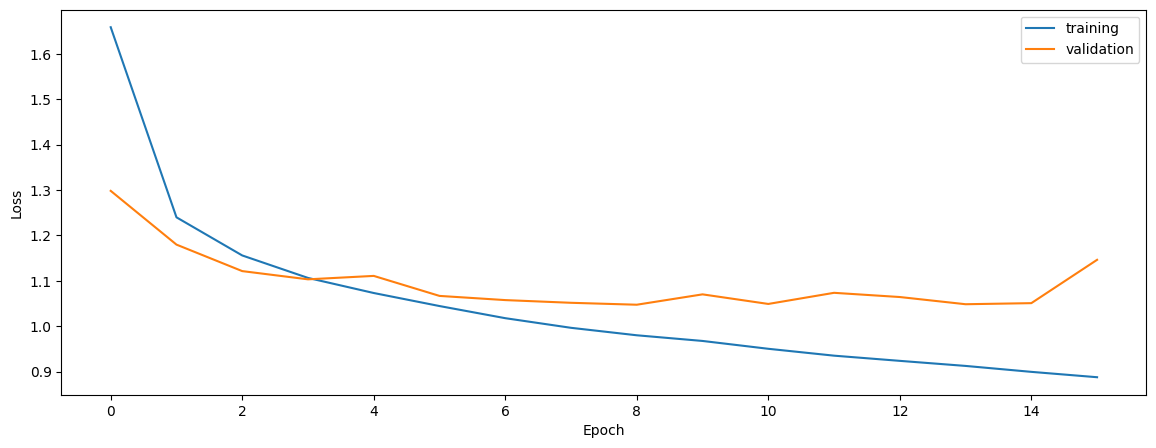

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getAccuracy, predictInBatches

train.append(predictInBatches(model,train[0],architecture['batch_size']))
val.append(predictInBatches(model,val[0],architecture['batch_size']))
test.append(predictInBatches(model,test[0],architecture['batch_size']))

print('train')
print(getAccuracy(train[1],train[4]))
print(getAccuracy(val[1],val[4]))
print(getAccuracy(test[1],test[4]))

train
0.6139703226091037
0.5861025022020683
0.577150544725527


In [8]:
print(props['space'])
print(getAccuracy(train[1],train[4],train[3][0]))
print(getAccuracy(val[1],val[4],val[3][0]))
print(getAccuracy(test[1],test[4],test[3][0]))

native
0.6331620896030143
0.624790220164147
0.5875353343909566


In [9]:
print('normalized' if props['space'] == 'native' else 'native')
print(getAccuracy(train[1][train[2]],train[4][train[2]],train[3][1]))
print(getAccuracy(val[1][val[2]],val[4][val[2]],val[3][1]))
print(getAccuracy(test[1][test[2]],test[4][test[2]],test[3][1]))

normalized
0.632145883976009
0.6222517353951785
0.5837969071580297


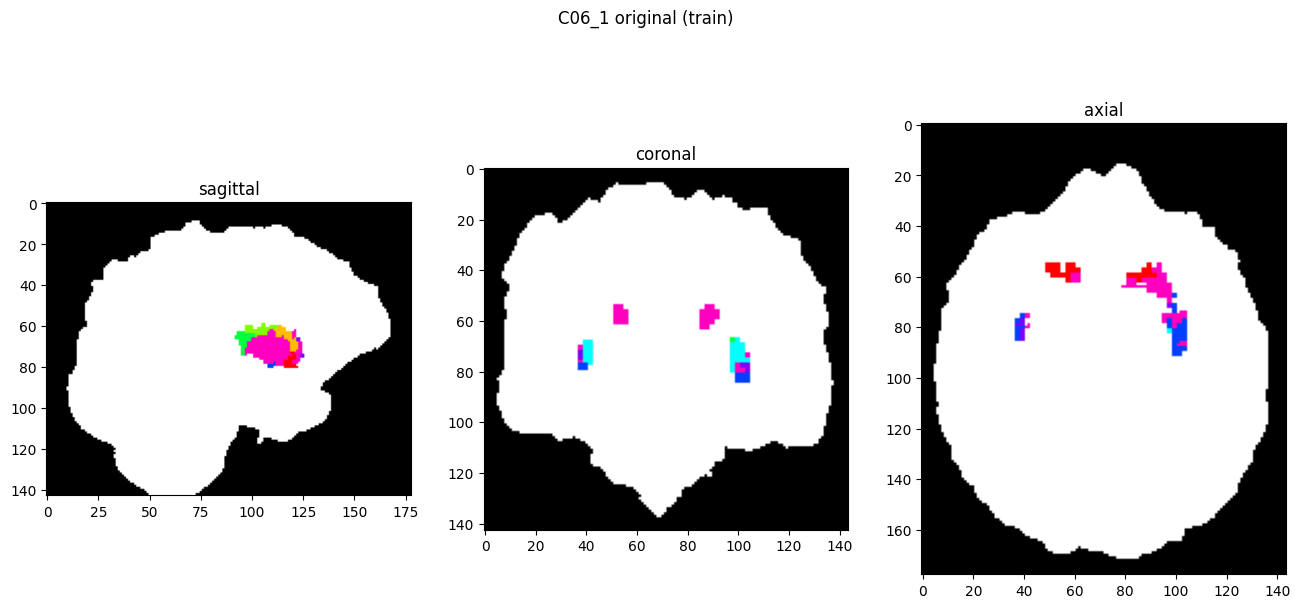

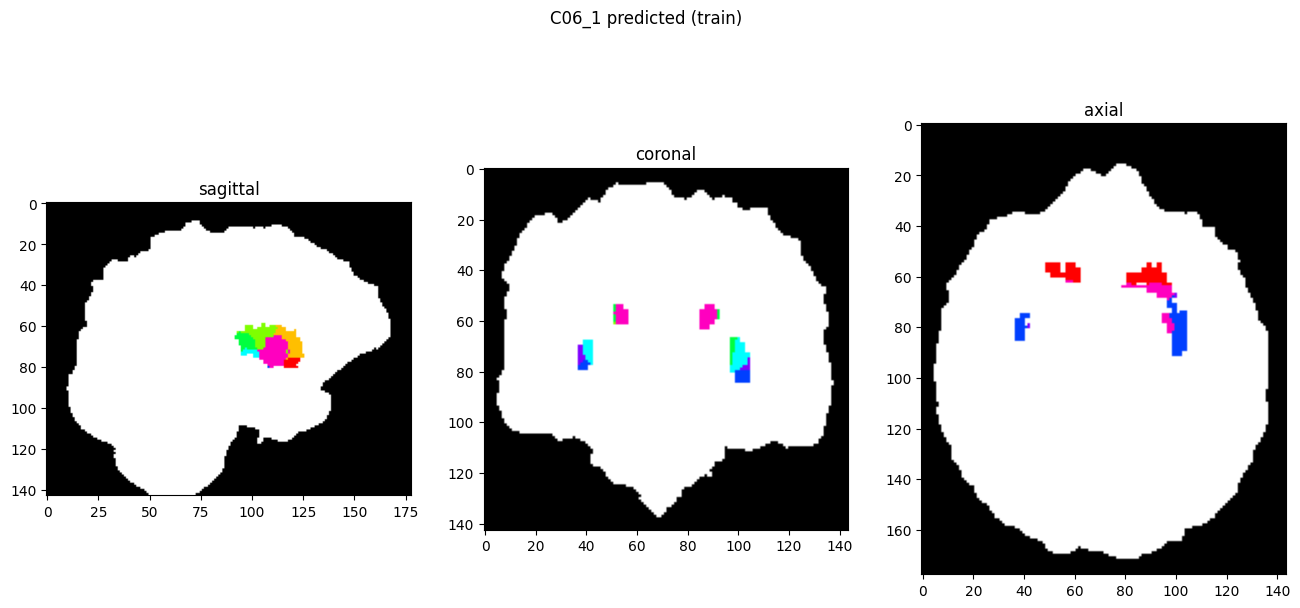

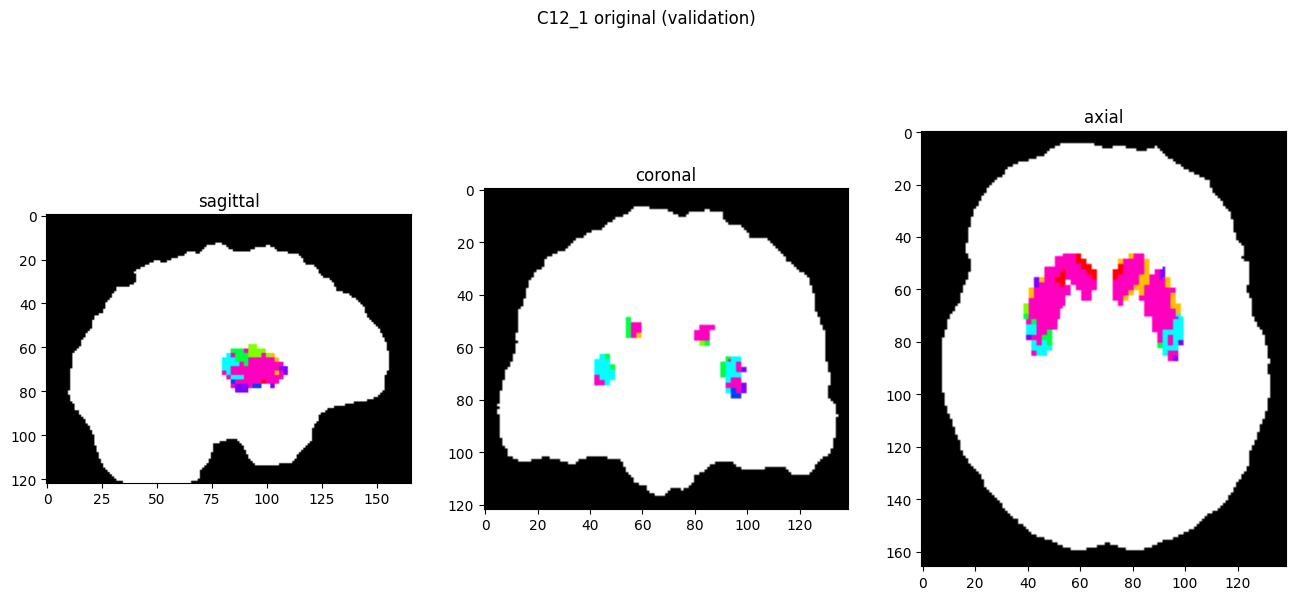

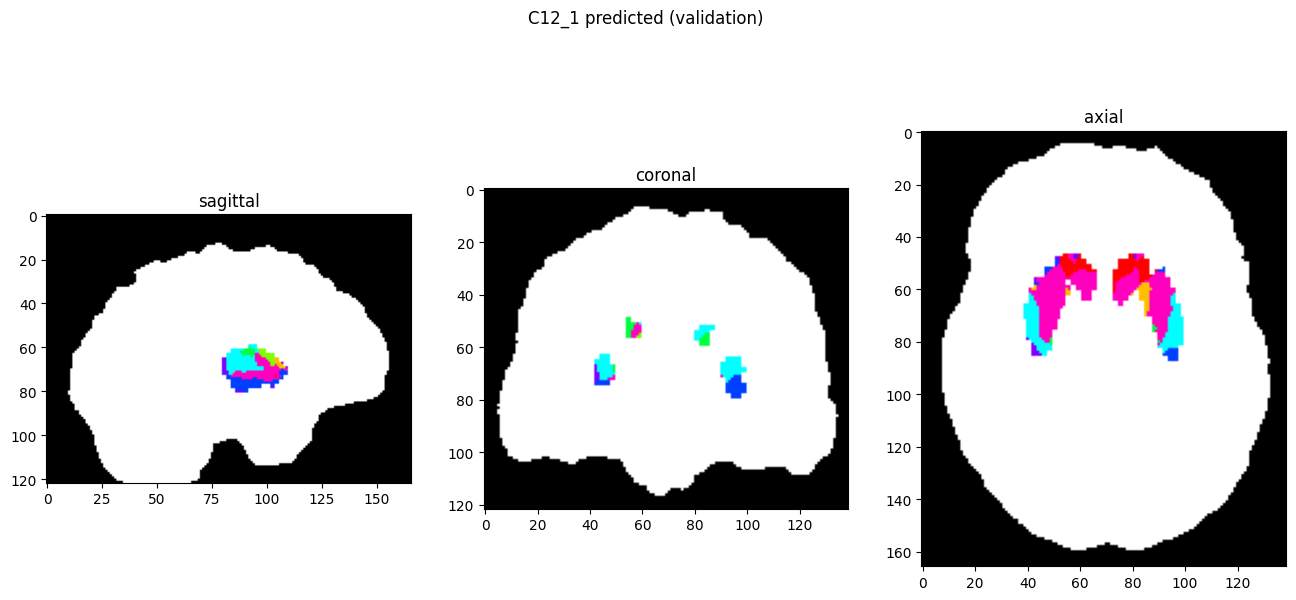

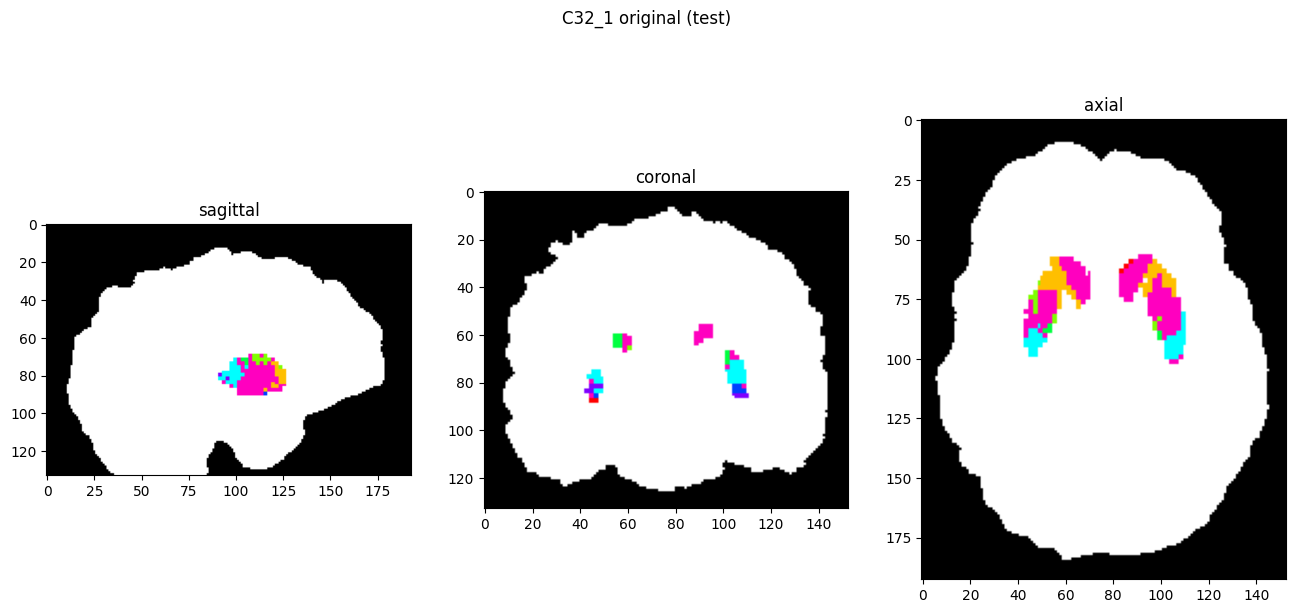

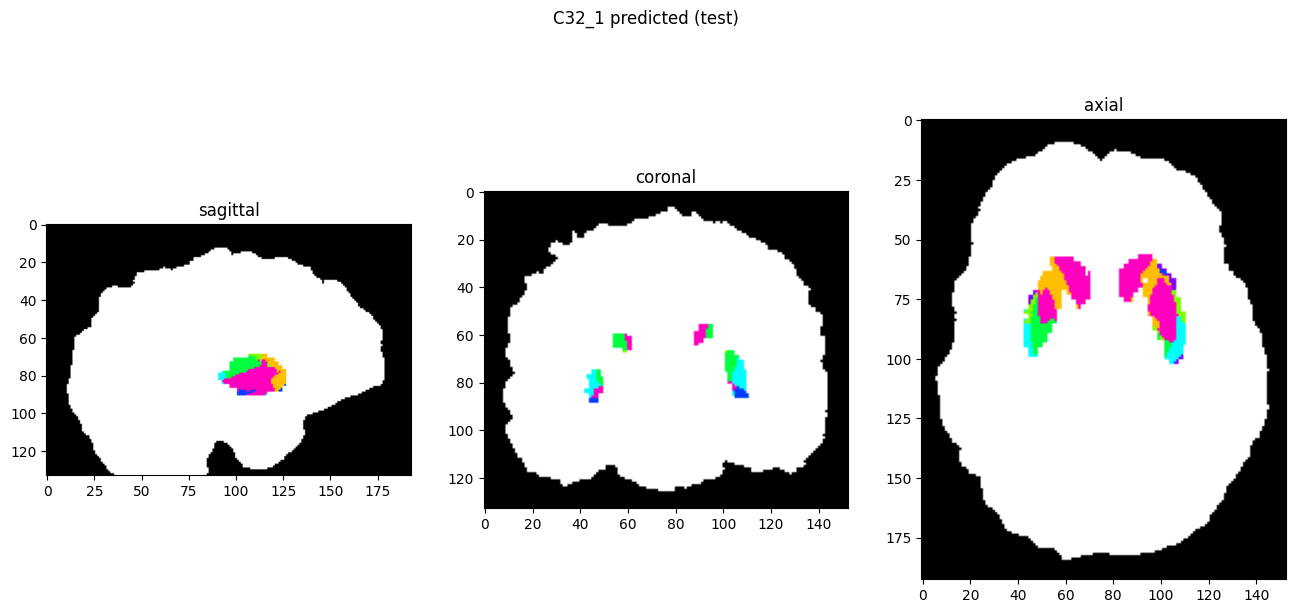

In [10]:
showResults(model, gen, threshold=0)